# 1.0 Data Ingestion

In [1]:
import os
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../artifacts/dataset/01-hourly_historical_analyzed_data.csv')
df = df.drop(columns=['hour', 'day', 'month', 'year'])
df

,time,temperature_2m,relative_humidity_2m,dew_point_2m,rain,cloud_cover_low,cloud_cover_mid,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_speed_100m,wind_gusts_10m
0,2000-01-01 00:00:00,4.0,96,3.3,0.0,0,0,0.00,0.04,3.8,3.6,11.5
1,2000-01-01 01:00:00,4.1,95,3.3,0.0,0,1,0.00,0.04,4.1,4.4,11.9
2,2000-01-01 02:00:00,4.0,95,3.2,0.0,0,1,0.01,0.04,3.8,4.5,11.9
3,2000-01-01 03:00:00,6.5,92,5.3,0.0,0,3,0.02,0.07,4.3,4.0,13.0
4,2000-01-01 04:00:00,12.9,75,8.6,0.0,0,0,0.13,0.37,2.0,2.5,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...
217699,2024-10-31 19:00:00,17.1,84,14.4,0.0,0,0,0.00,0.31,4.6,7.9,8.6
217700,2024-10-31 20:00:00,17.2,80,13.8,0.0,0,0,0.00,0.39,3.3,4.6,7.2
217701,2024-10-31 21:00:00,17.3,77,13.2,0.0,0,0,0.00,0.46,3.1,2.6,5.8
217702,2024-10-31 22:00:00,16.8,78,13.0,0.0,0,0,0.00,0.42,4.8,4.3,6.8


# 2.0 Data Preprocessing

#### For Events: Cloudbursts (CB) & Mini-Cloudbursts (MCB) based on periods with rainfall intensities.

1. **No Rain**: Rainfall > 0 mm/hr
2. **Trace Rainfall**: Rainfall > 0.0004 to 0.002 mm/hr
3. **Very Light Rainfall**: Rainfall > 0.004 to 0.1 mm/hr
4. **Light Rainfall**: Rainfall > 0.3 mm/hr
5. **Moderate Rainfall**: Rainfall > 1.5 mm/hr
6. **Heavy Rainfall**: Rainfall > *6.5 cm/day* = 0.27 cm/hr = 2.7 mm/hr
7. **Very Heavy Rainfall**: Rainfall > *13.0 cm/day* = 0.55 cm/hr = 5.5 mm/hr
8. **Extremely Heavy Rainfall**: Rainfall > *20.0 cm/day* = 0.85 cm/hr = 8.5 mm/hr
9. **Mini-Cloud Burst (MCB)**: Rainfall exceeds *5 cm over any two consecutive hours* = 2.5 cm/hr = 25 mm/hr
10. **Cloudburst (CB)**: Rainfall > *10 cm in a single hour* = 10 cm/hr = 100 mm/hr

## 2.1 Outlier Detection

In [3]:
from scipy.stats import zscore

def detect_outliers(dataframe, target_columns):
    """
    Detects outliers in the specified columns of a dataframe using three methods:
    1. Percentile-based
    2. Standard Deviation-based
    3. Z-score-based
    
    Parameters:
        dataframe (pd.DataFrame): The input dataframe.
        target_columns (list): List of columns to check for outliers.
        
    Returns:
        pd.DataFrame: A dataframe containing all detected outliers (with duplicates removed).
    """
    outliers_df = pd.DataFrame()

    # Method 1: Outliers based on Percentiles
    percentiles = dataframe[target_columns].quantile([0.001, 0.999])
    for col in target_columns:
        lower_limit, upper_limit = percentiles.loc[0.001, col], percentiles.loc[0.999, col]
        percentile_outliers = dataframe[(dataframe[col] < lower_limit) | (dataframe[col] > upper_limit)]
        outliers_df = pd.concat([outliers_df, percentile_outliers])
    
    print(f'Outliers based on Percentiles: {percentile_outliers.shape[0]}')

    # Method 2: Outliers based on Standard Deviation
    for col in target_columns:
        mean, std_dev = dataframe[col].mean(), dataframe[col].std()
        max_limit, min_limit = mean + 3 * std_dev, mean - 3 * std_dev
        std_dev_outliers = dataframe[(dataframe[col] < min_limit) | (dataframe[col] > max_limit)]
        outliers_df = pd.concat([outliers_df, std_dev_outliers])
    
    print(f'Outliers based on Standard Deviation: {std_dev_outliers.shape[0]}')

    # Method 3: Outliers based on Z-score
    for col in target_columns:
        z_scores = zscore(dataframe[col])
        z_score_outliers = dataframe[(z_scores < -3) | (z_scores > 3)]
        outliers_df = pd.concat([outliers_df, z_score_outliers])
    
    print(f'Outliers based on Z-score: {z_score_outliers.shape[0]}')

    # Remove duplicates to avoid counting the same outlier multiple times across methods
    outliers_df = outliers_df.drop_duplicates()
    
    return outliers_df

In [4]:
target_columns = [
    'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'cloud_cover_low', 'cloud_cover_mid', 'et0_fao_evapotranspiration', 'vapour_pressure_deficit', 'wind_speed_10m', 'wind_speed_100m', 'wind_gusts_10m'
]
outliers = detect_outliers(df, target_columns)
print(f'Total unique outliers detected: {outliers.shape[0]}')

Outliers based on Percentiles: 349
Outliers based on Standard Deviation: 2658
Outliers based on Z-score: 2658
Total unique outliers detected: 24708


In [5]:
outliers_df = detect_outliers(df, ['rain'])
print(f'Total unique outliers detected: {outliers_df.shape[0]}')

print(f'Total unique outliers detected for the column "rain": {outliers_df.rain.unique().shape[0]}')

Outliers based on Percentiles: 217
Outliers based on Standard Deviation: 3104
Outliers based on Z-score: 3104
Total unique outliers detected: 3104
Total unique outliers detected for the column "rain": 182


## 2.2 Date-time index transformation

In [6]:
df1 = df.copy()

df1.index = pd.to_datetime(df1['time'], format='%Y-%m-%d %H:%M:%S')
df1

,time,temperature_2m,relative_humidity_2m,dew_point_2m,rain,cloud_cover_low,cloud_cover_mid,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_speed_100m,wind_gusts_10m
time,,,,,,,,,,,,
2000-01-01 00:00:00,2000-01-01 00:00:00,4.0,96,3.3,0.0,0,0,0.00,0.04,3.8,3.6,11.5
2000-01-01 01:00:00,2000-01-01 01:00:00,4.1,95,3.3,0.0,0,1,0.00,0.04,4.1,4.4,11.9
2000-01-01 02:00:00,2000-01-01 02:00:00,4.0,95,3.2,0.0,0,1,0.01,0.04,3.8,4.5,11.9
2000-01-01 03:00:00,2000-01-01 03:00:00,6.5,92,5.3,0.0,0,3,0.02,0.07,4.3,4.0,13.0
2000-01-01 04:00:00,2000-01-01 04:00:00,12.9,75,8.6,0.0,0,0,0.13,0.37,2.0,2.5,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31 19:00:00,2024-10-31 19:00:00,17.1,84,14.4,0.0,0,0,0.00,0.31,4.6,7.9,8.6
2024-10-31 20:00:00,2024-10-31 20:00:00,17.2,80,13.8,0.0,0,0,0.00,0.39,3.3,4.6,7.2
2024-10-31 21:00:00,2024-10-31 21:00:00,17.3,77,13.2,0.0,0,0,0.00,0.46,3.1,2.6,5.8


## 2.3 Yearly Rain Plot

<Axes: xlabel='time'>

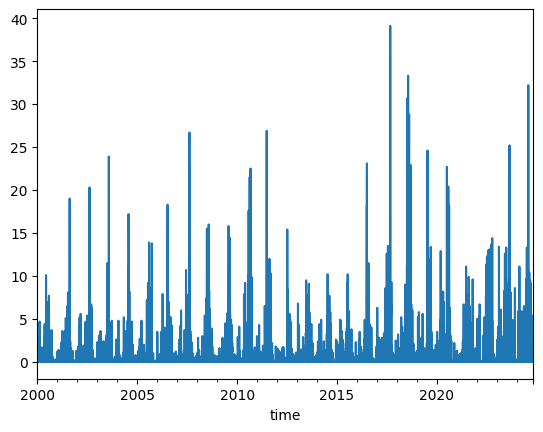

In [7]:
rain = df1['rain']
rain.plot()

## 2.4 For Multivariate: Converting TIme Stamp into usable signals

time stamp (using rain col):
1. day sin & day cos
2. year sin & year cos

In [8]:
rain_df = pd.DataFrame({'Rain': rain})
rain_df

,Rain
time,
2000-01-01 00:00:00,0.0
2000-01-01 01:00:00,0.0
2000-01-01 02:00:00,0.0
2000-01-01 03:00:00,0.0
2000-01-01 04:00:00,0.0
...,...
2024-10-31 19:00:00,0.0
2024-10-31 20:00:00,0.0
2024-10-31 21:00:00,0.0


In [9]:
rain_df[rain_df['Rain'] != 0]['Rain']

time
2000-01-09 04:00:00    0.1
2000-01-11 02:00:00    0.2
2000-01-11 03:00:00    0.3
2000-01-12 04:00:00    0.2
2000-01-12 05:00:00    0.6
                      ... 
2024-10-14 09:00:00    0.1
2024-10-21 08:00:00    0.1
2024-10-21 09:00:00    0.1
2024-10-26 01:00:00    0.1
2024-10-26 11:00:00    0.1
Name: Rain, Length: 35952, dtype: float64

In [10]:
rain_df['Seconds'] = rain_df.index.map(pd.Timestamp.timestamp)
rain_df

,Rain,Seconds
time,,
2000-01-01 00:00:00,0.0,9.466848e+08
2000-01-01 01:00:00,0.0,9.466884e+08
2000-01-01 02:00:00,0.0,9.466920e+08
2000-01-01 03:00:00,0.0,9.466956e+08
2000-01-01 04:00:00,0.0,9.466992e+08
...,...,...
2024-10-31 19:00:00,0.0,1.730401e+09
2024-10-31 20:00:00,0.0,1.730405e+09
2024-10-31 21:00:00,0.0,1.730408e+09


In [11]:
day = 24 * 60 * 60
year = (365.2425) * day

rain_df['Day sin'] = np.sin(rain_df['Seconds'] * (2 * np.pi / day))
rain_df['Day cos'] = np.cos(rain_df['Seconds'] * (2 * np.pi / day))
rain_df['Year sin'] = np.sin(rain_df['Seconds'] * (2 * np.pi / year))
rain_df['Year cos'] = np.cos(rain_df['Seconds'] * (2 * np.pi / year))
rain_df

,Rain,Seconds,Day sin,Day cos,Year sin,Year cos
time,,,,,,
2000-01-01 00:00:00,0.0,9.466848e+08,-5.461913e-12,1.000000,-0.004731,0.999989
2000-01-01 01:00:00,0.0,9.466884e+08,2.588190e-01,0.965926,-0.004014,0.999992
2000-01-01 02:00:00,0.0,9.466920e+08,5.000000e-01,0.866025,-0.003297,0.999995
2000-01-01 03:00:00,0.0,9.466956e+08,7.071068e-01,0.707107,-0.002580,0.999997
2000-01-01 04:00:00,0.0,9.466992e+08,8.660254e-01,0.500000,-0.001864,0.999998
...,...,...,...,...,...,...
2024-10-31 19:00:00,0.0,1.730401e+09,-9.659258e-01,0.258819,-0.863191,0.504877
2024-10-31 20:00:00,0.0,1.730405e+09,-8.660254e-01,0.500000,-0.862829,0.505496
2024-10-31 21:00:00,0.0,1.730408e+09,-7.071068e-01,0.707107,-0.862466,0.506114


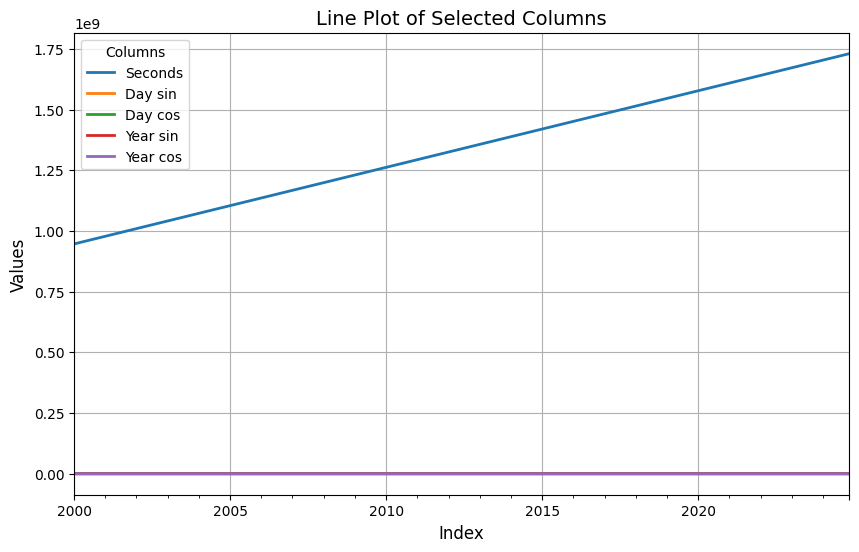

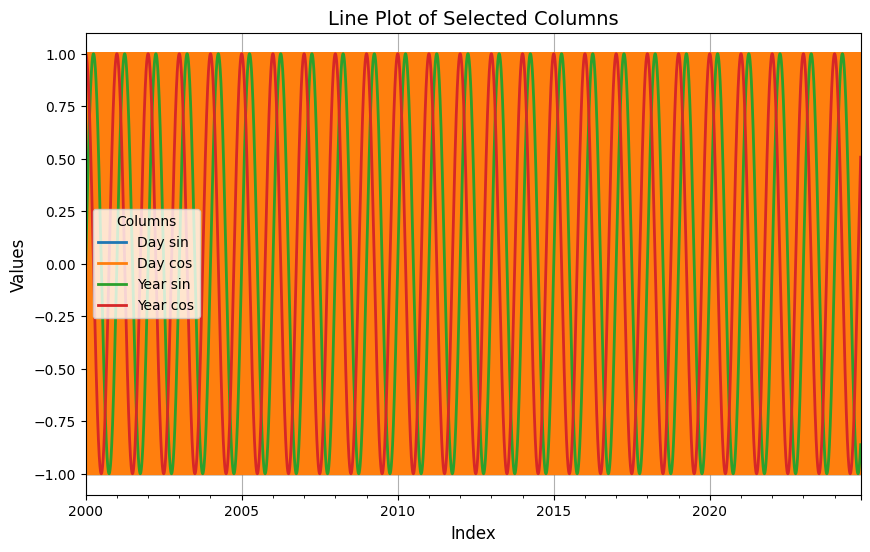

In [12]:
def plot_columns(df, columns_to_plot):
    """
    Plots specified columns of a DataFrame.

    Parameters:
    - df: pandas DataFrame
    - columns_to_plot: List of column names to plot
    """

    # Plot the data
    df[columns_to_plot].plot(
        figsize=(10, 6),
        linewidth=2
    )

    # Customize the plot
    plt.xlabel('Index', fontsize=12)
    plt.ylabel('Values', fontsize=12)
    plt.title(f'Line Plot of Selected Columns', fontsize=14)
    plt.legend(title='Columns', fontsize=10)
    plt.grid(True)
    plt.show()

plot_columns(rain_df, ['Seconds', 'Day sin', 'Day cos', 'Year sin', 'Year cos'])

plot_columns(rain_df, ['Day sin', 'Day cos', 'Year sin', 'Year cos'])

In [13]:
rain_df = rain_df.drop(['Seconds'], axis=1)
rain_df.columns

Index(['Rain', 'Day sin', 'Day cos', 'Year sin', 'Year cos'], dtype='object')

## 2.5 Batch Windowing

In [14]:
# [[[r1, ds1, dc1], [r2, ds2, dc2], [r3, ds3, dc3], [r4, ds4, dc4], [r5, ds5, dc5]]] = [r6]
# [[[r2, ds2], [r3, ds3], [r4, ds4], [r5, ds5], [r6, ds6]]] = [r7]
# [[[r3, ds3], [r4, ds4], [r5, ds5], [r6, ds6], [r7, ds7]]] = [r8]

def df_to_X_y(df, window_size=6):
    df_as_np = df.to_numpy()
    X = []
    y = []
    
    for i in range(len(df_as_np) - window_size):
        row = [r for r in df_as_np[i: i + window_size]]
        X.append(row)
        
        label = df_as_np[i + window_size][0]
        y.append(label)
    
    return np.array(X), np.array(y)

In [15]:
X1, y1 = df_to_X_y(rain_df)
X1.shape, y1.shape

((217698, 6, 5), (217698,))

## 2.6 Train Test Val Split

In [16]:
X_train1, y_train1 = X1[:200000], y1[:200000]
X_val1, y_val1 = X1[200000:209000], y1[200000:209000]
X_test1, y_test1 = X1[209000:], y1[209000:]

X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((200000, 6, 5), (200000,), (9000, 6, 5), (9000,), (8698, 6, 5), (8698,))

## 2.7 Standardization (Standard Normal Distribution)

In [17]:
rain_df.Rain.unique()

array([ 0. ,  0.1,  0.2,  0.3,  0.6,  0.4,  0.7,  0.5,  0.9,  1.1,  0.8,
        1.4,  1.3,  2. ,  2.3,  1. ,  1.2,  1.5,  3. ,  2.7,  1.6,  1.9,
        3.3,  4.7,  3.9,  3.4,  2.5,  2.2,  2.1,  1.7,  1.8,  4.4,  3.1,
        2.4,  4.2,  4.3,  6.5,  7.6,  8.6,  8.9,  7.7,  7.8, 10.1,  9.7,
        9.6,  8.7,  8.3,  7.3,  4.5,  3.5,  3.2,  2.6,  2.8,  6.4,  4.9,
        5.2,  6. ,  3.7,  3.6,  3.8,  2.9,  4.8,  6.7,  5.9,  7. ,  5.1,
        4.6,  5.4,  5.5,  4.1,  6.1,  8.1,  5. , 12.4, 15.9, 17.9, 19. ,
       18.7, 17.4, 14.1,  9.8,  6.9,  5.3,  5.6,  6.3,  9.2, 13.9, 19.3,
       16.7, 18.8, 18.6, 15.4, 10.9,  8.2, 12. , 15.6, 16.9, 20.3,  4. ,
       11.5, 11.4,  9.4,  8. , 15.8, 19.8, 22.8, 23.9, 23.5, 21.1, 12.5,
       10.7,  9. , 11.6, 14.5, 16.5, 17.2, 16.4, 15.2,  9.5,  7.9,  8.4,
        6.6,  7.1, 10.3, 10.8,  7.2, 11.2,  6.2,  6.8,  9.3, 11.9, 13.8,
       13.3, 13.2,  5.7, 15.7, 18.3,  5.8, 21. , 19.9, 21.4, 25.1, 26.7,
       22.9,  8.8,  7.4, 11. , 13.7, 15. , 15.5, 14

In [18]:
rain_training_mean = np.mean(X_train1[:, :, 0])
rain_training_std = np.std(X_train1[:, :, 0])

def preprocess_standardize(X):
    X[:, :, 0] = (X[:, :, 0] - rain_training_mean) / rain_training_std
    return X

In [19]:
preprocess_standardize(X_train1)
preprocess_standardize(X_val1)
preprocess_standardize(X_test1)

array([[[-1.98473682e-01,  8.66025404e-01, -5.00000000e-01,
         -8.38029166e-01,  5.45625436e-01],
        [-1.98473682e-01,  7.07106781e-01, -7.07106781e-01,
         -8.37637856e-01,  5.46225980e-01],
        [-1.98473682e-01,  5.00000000e-01, -8.66025404e-01,
         -8.37246116e-01,  5.46826244e-01],
        [-1.98473682e-01,  2.58819045e-01, -9.65925826e-01,
         -8.36853946e-01,  5.47426227e-01],
        [-1.98473682e-01,  6.44024848e-12, -1.00000000e+00,
         -8.36461345e-01,  5.48025928e-01],
        [-1.98473682e-01, -2.58819045e-01, -9.65925826e-01,
         -8.36068315e-01,  5.48625348e-01]],

       [[-1.98473682e-01,  7.07106781e-01, -7.07106781e-01,
         -8.37637856e-01,  5.46225980e-01],
        [-1.98473682e-01,  5.00000000e-01, -8.66025404e-01,
         -8.37246116e-01,  5.46826244e-01],
        [-1.98473682e-01,  2.58819045e-01, -9.65925826e-01,
         -8.36853946e-01,  5.47426227e-01],
        [-1.98473682e-01,  6.44024848e-12, -1.00000000e+00,
  

## 2.8 Combining 'df1' & 'rain_df'

In [20]:
df2 = pd.concat([df1, rain_df], axis=1)
df2 = df2.drop(['time','rain'], axis=1)
df2

,temperature_2m,relative_humidity_2m,dew_point_2m,cloud_cover_low,cloud_cover_mid,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_speed_100m,wind_gusts_10m,Rain,Day sin,Day cos,Year sin,Year cos
time,,,,,,,,,,,,,,,
2000-01-01 00:00:00,4.0,96,3.3,0,0,0.00,0.04,3.8,3.6,11.5,0.0,-5.461913e-12,1.000000,-0.004731,0.999989
2000-01-01 01:00:00,4.1,95,3.3,0,1,0.00,0.04,4.1,4.4,11.9,0.0,2.588190e-01,0.965926,-0.004014,0.999992
2000-01-01 02:00:00,4.0,95,3.2,0,1,0.01,0.04,3.8,4.5,11.9,0.0,5.000000e-01,0.866025,-0.003297,0.999995
2000-01-01 03:00:00,6.5,92,5.3,0,3,0.02,0.07,4.3,4.0,13.0,0.0,7.071068e-01,0.707107,-0.002580,0.999997
2000-01-01 04:00:00,12.9,75,8.6,0,0,0.13,0.37,2.0,2.5,13.0,0.0,8.660254e-01,0.500000,-0.001864,0.999998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-31 19:00:00,17.1,84,14.4,0,0,0.00,0.31,4.6,7.9,8.6,0.0,-9.659258e-01,0.258819,-0.863191,0.504877
2024-10-31 20:00:00,17.2,80,13.8,0,0,0.00,0.39,3.3,4.6,7.2,0.0,-8.660254e-01,0.500000,-0.862829,0.505496
2024-10-31 21:00:00,17.3,77,13.2,0,0,0.00,0.46,3.1,2.6,5.8,0.0,-7.071068e-01,0.707107,-0.862466,0.506114


In [21]:
df2.columns

Index(['temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'cloud_cover_low', 'cloud_cover_mid', 'et0_fao_evapotranspiration',
       'vapour_pressure_deficit', 'wind_speed_10m', 'wind_speed_100m',
       'wind_gusts_10m', 'Rain', 'Day sin', 'Day cos', 'Year sin', 'Year cos'],
      dtype='object')

## 2.9 Batch Windowing for the whole df

In [22]:
remaining_columns_to_target = [
    'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'cloud_cover_low', 
    'cloud_cover_mid', 'et0_fao_evapotranspiration', 'vapour_pressure_deficit', 
    'wind_speed_10m', 'wind_speed_100m', 'wind_gusts_10m'
]

In [23]:
# [[[r1, ds1, dc1], [r2, ds2, dc2], [r3, ds3, dc3], [r4, ds4, dc4], [r5, ds5, dc5]]] = [r6]
# [[[r2, ds2], [r3, ds3], [r4, ds4], [r5, ds5], [r6, ds6]]] = [r7]
# [[[r3, ds3], [r4, ds4], [r5, ds5], [r6, ds6], [r7, ds7]]] = [r8]

# X2, y2 = df_to_X_y(df2, window_size=16)
X2, y2 = df_to_X_y(df2)
X2.shape, y2.shape

((217698, 6, 15), (217698,))

## 2.10 Train Test Val Split

In [24]:
df2.shape

(217704, 15)

In [25]:
def split_time_series_data(X, y, train_ratio=0.8, val_ratio=0.1):
    """
    Splits time series data into training, validation, and testing sets sequentially.

    Parameters:
    - X: Features (numpy array, DataFrame).
    - y: Labels (numpy array, Series).
    - train_ratio: Proportion of data for training (default 0.8).
    - val_ratio: Proportion of data for validation (default 0.1).

    Returns:
    - X_train, X_val, X_test, y_train, y_val, y_test: Sequentially split data.
    """
    # Calculate the number of samples for each split
    n = len(X)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)

    # Split data sequentially
    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [26]:
# 80% Training: First 800 samples.
# 10% Validation: Next 100 samples.
# 10% Testing: Final 100 samples.

X_train2, X_val2, X_test2, y_train2, y_val2, y_test2 = split_time_series_data(X2, y2)
X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

((174158, 6, 15),
 (174158,),
 (21769, 6, 15),
 (21769,),
 (21771, 6, 15),
 (21771,))

## 2.11 Standardization of i/p & o/p

In [27]:
rain_training_mean2 = np.mean(X_train2[:, :, 0])
rain_training_std2 = np.std(X_train2[:, :, 0])

def preprocess_standardize2(X):
    X[:, :, 0] = (X[:, :, 0] - rain_training_mean2) / rain_training_std2
    return X

def preprocess__standardize_output(y):
    # Check if y is 1D or 2D
    if len(y.shape) == 2:  # If it's 2D (like a column vector), you can index it
        y[:, 0] = (y[:, 0] - rain_training_mean2) / rain_training_std2
    else:  # If it's 1D, you don't need the extra index
        y = (y - rain_training_mean2) / rain_training_std2
    return y

In [28]:
preprocess_standardize2(X_train2)
preprocess_standardize2(X_val2)
preprocess_standardize2(X_test2)

array([[[ 4.05254241e-01,  7.00000000e+01,  1.76000000e+01, ...,
         -7.07106781e-01,  8.07191772e-01, -5.90289287e-01],
        [ 2.32306907e-01,  7.30000000e+01,  1.71000000e+01, ...,
         -5.00000000e-01,  8.06768456e-01, -5.90867716e-01],
        [ 1.52485061e-01,  7.40000000e+01,  1.68000000e+01, ...,
         -2.58819045e-01,  8.06344725e-01, -5.91445842e-01],
        [ 9.92704967e-02,  7.50000000e+01,  1.66000000e+01, ...,
         -8.84878985e-12,  8.05920580e-01, -5.92023664e-01],
        [ 1.25877779e-01,  7.00000000e+01,  1.58000000e+01, ...,
          2.58819045e-01,  8.05496021e-01, -5.92601181e-01],
        [ 7.26632146e-02,  7.10000000e+01,  1.55000000e+01, ...,
          5.00000000e-01,  8.05071048e-01, -5.93178394e-01]],

       [[ 2.32306907e-01,  7.30000000e+01,  1.71000000e+01, ...,
         -5.00000000e-01,  8.06768456e-01, -5.90867716e-01],
        [ 1.52485061e-01,  7.40000000e+01,  1.68000000e+01, ...,
         -2.58819045e-01,  8.06344725e-01, -5.91445

In [29]:
preprocess__standardize_output(y_train2)
preprocess__standardize_output(y_val2)
preprocess__standardize_output(y_test2)

array([-0.02046227,  0.08596686,  0.12587778, ..., -0.4195715 ,
       -0.48608971, -0.49939335])

# 3.0 Model

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

## 3.1 LSTM

In [31]:
model_lstm = Sequential([
    InputLayer((16, 15)),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(16, 'relu'),
    Dense(8, 'relu'),
    Dense(1, 'linear')
])

model_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 16, 32)         │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,065 (172.13 KB)

 Trainable params: 44,065 (172.13 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
def train_model(model, checkpoint_path, X_train, y_train, X_val, y_val, epochs=2, learning_rate=0.0001):
    """
    Function to compile and train a model with specified parameters.
    
    Args:
    - model: The Keras model to be trained.
    - checkpoint_path: File path to save the best model during training.
    - X_train, y_train: Training data and labels.
    - X_val, y_val: Validation data and labels.
    - epochs: Number of epochs for training (default: 2).
    - learning_rate: Learning rate for the optimizer (default: 0.0001).
    
    Returns:
    - history: Training history object.
    """
    # Define the model checkpoint
    checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=MeanSquaredError(),
        metrics=[RootMeanSquaredError()]
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        callbacks=[checkpoint]
    )

    return history

In [33]:
history_lstm = train_model(
    model=model_lstm,
    checkpoint_path='../artifacts/models/multivariate/model_lstm.keras',
    X_train=X_train2,
    y_train=y_train2,
    X_val=X_val2,
    y_val=y_val2,
    epochs=2
)

Epoch 1/2
5443/5443 ━━━━━━━━━━━━━━━━━━━━ 45s 7ms/step - loss: 49.4489 - root_mean_squared_error: 6.4251 - val_loss: 20.1404 - val_root_mean_squared_error: 4.4878
Epoch 2/2
5443/5443 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - loss: 3.0371 - root_mean_squared_error: 1.7404 - val_loss: 17.3218 - val_root_mean_squared_error: 4.1619


In [34]:
model_lstm = load_model('../artifacts/models/multivariate/model_lstm.keras')

## 3.2 LSTM Plot: Pred v/s Actual

In [35]:
def plot_predictions(model, X_data, y_data, label, start=50, end=500, ylabel='Rainfall (mm)', title_suffix=''):
    """
    Plots predictions vs actual values for a given model and dataset.
    
    Args:
    - model: The trained model to use for predictions.
    - X_data: Input data for predictions.
    - y_data: Actual target values.
    - label: A string indicating the dataset (e.g., 'Train', 'Validation', 'Test').
    - start, end: Range of data points to visualize (default: 50 to 500).
    - ylabel: Label for the y-axis (default: 'Rainfall (mm)').
    - title_suffix: Additional suffix for the title (optional).
    
    Returns:
    - A DataFrame containing the predictions and actual values.
    """
    # Make predictions
    predictions = model.predict(X_data).flatten()

    # Create a DataFrame to store results
    results_df = pd.DataFrame(data={f'{label} Predictions': predictions, 'Actual Values': y_data})
    print(results_df)

    # Plot the predictions and actual values
    plt.figure(figsize=(10, 6))
    plt.plot(results_df[f'{label} Predictions'][start:end], label=f'{label} Predictions', color='blue', linestyle='-')
    plt.plot(results_df['Actual Values'][start:end], label='Actual Values', color='orange', linestyle='--')

    # Add labels and title
    plt.xlabel('Time Stamps', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(f'{label} Predictions vs Actual Values {title_suffix}', fontsize=14)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    return results_df

5443/5443 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
        Train Predictions  Actual Values
0               12.368612           16.3
1               14.305376           16.7
2               14.454345           17.0
3               14.213137           16.9
4               13.182138           16.5
...                   ...            ...
174153          13.042938           18.9
174154          14.067058           18.4
174155          13.438757           16.1
174156          12.381374           17.1
174157          13.543774           17.5

[174158 rows x 2 columns]


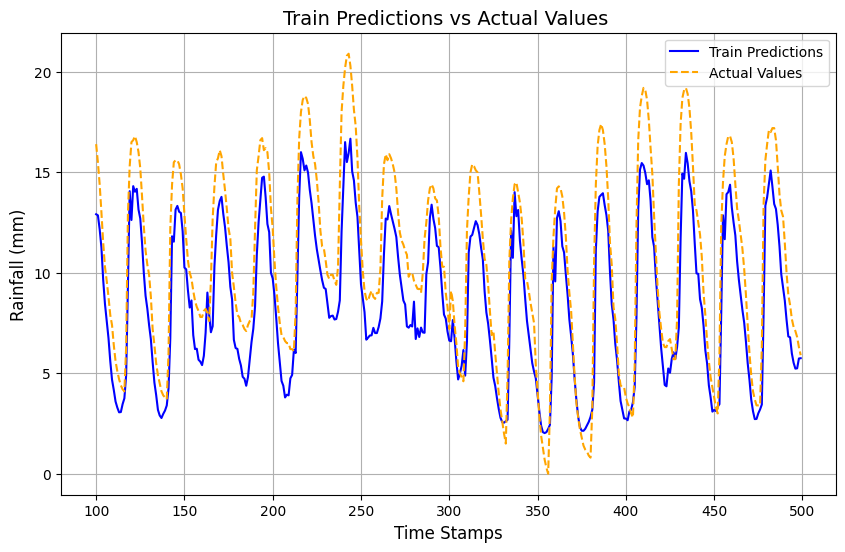

In [36]:
train_results = plot_predictions(
    model=model_lstm, 
    X_data=X_train2, 
    y_data=y_train2, 
    label='Train', 
    start=100, 
    end=500
)

681/681 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
       Val Predictions  Actual Values
0            13.333579           18.6
1            14.331906           14.7
2            11.787657           15.4
3            13.288504           18.3
4            15.681289           17.2
...                ...            ...
21764        19.103189           22.2
21765        18.020359           21.6
21766        16.714828           21.2
21767        16.677954           21.4
21768        17.016775           21.0

[21769 rows x 2 columns]


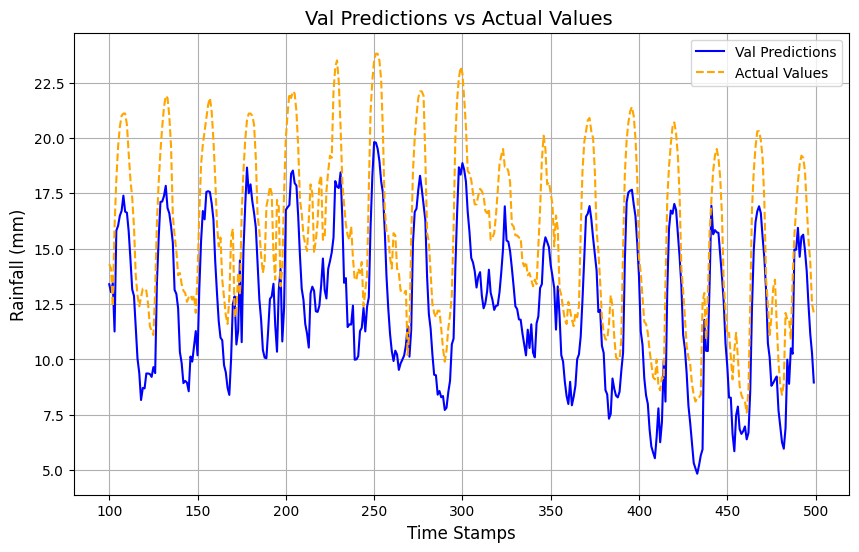

In [37]:
val_results = plot_predictions(
    model=model_lstm, 
    X_data=X_val2, 
    y_data=y_val2, 
    label='Val', 
    start=100, 
    end=500
)

681/681 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
       Test Predictions  Actual Values
0             16.662342           20.3
1             16.718313           21.1
2             18.093594           21.4
3             18.770344           21.1
4             17.011189           23.5
...                 ...            ...
21766         13.077439           17.1
21767         13.532405           17.2
21768         13.360103           17.3
21769         14.025366           16.8
21770         13.438461           16.7

[21771 rows x 2 columns]


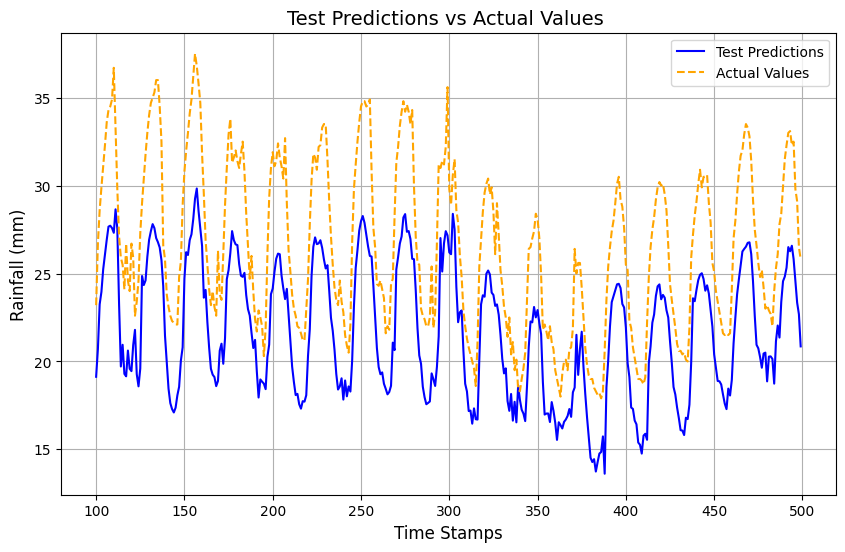

In [38]:
test_results = plot_predictions(
    model=model_lstm, 
    X_data=X_test2, 
    y_data=y_test2, 
    label='Test', 
    start=100, 
    end=500
)

## 3.3 GRU

In [39]:
model_gru = Sequential([
    InputLayer((16, 15)),
    GRU(32, activation='relu', return_sequences=True),
    GRU(64, activation='relu', return_sequences=True),
    GRU(32, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(16, 'relu'),
    Dense(8, 'relu'),
    Dense(1, 'linear')
])

model_gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 16, 32)         │         4,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 16, 64)         │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,601 (131.25 KB)

 Trainable params: 33,601 (131.25 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
history_gru = train_model(
    model=model_gru,
    checkpoint_path='../artifacts/models/multivariate/model_gru.keras',
    X_train=X_train2,
    y_train=y_train2,
    X_val=X_val2,
    y_val=y_val2,
    epochs=2
)

Epoch 1/2
5443/5443 ━━━━━━━━━━━━━━━━━━━━ 56s 9ms/step - loss: 66.8992 - root_mean_squared_error: 7.3904 - val_loss: 13.0635 - val_root_mean_squared_error: 3.6143
Epoch 2/2
5443/5443 ━━━━━━━━━━━━━━━━━━━━ 56s 10ms/step - loss: 3.5123 - root_mean_squared_error: 1.8708 - val_loss: 16.2981 - val_root_mean_squared_error: 4.0371


In [41]:
model_gru = load_model('../artifacts/models/multivariate/model_gru.keras')

## 3.4 GRU Plot: Pred v/s Actual

5443/5443 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step
        Train Predictions  Actual Values
0               15.461607           16.3
1               15.577553           16.7
2               15.221794           17.0
3               14.835308           16.9
4               14.643984           16.5
...                   ...            ...
174153          14.589399           18.9
174154          14.186418           18.4
174155          13.356820           16.1
174156          12.270931           17.1
174157          14.201122           17.5

[174158 rows x 2 columns]


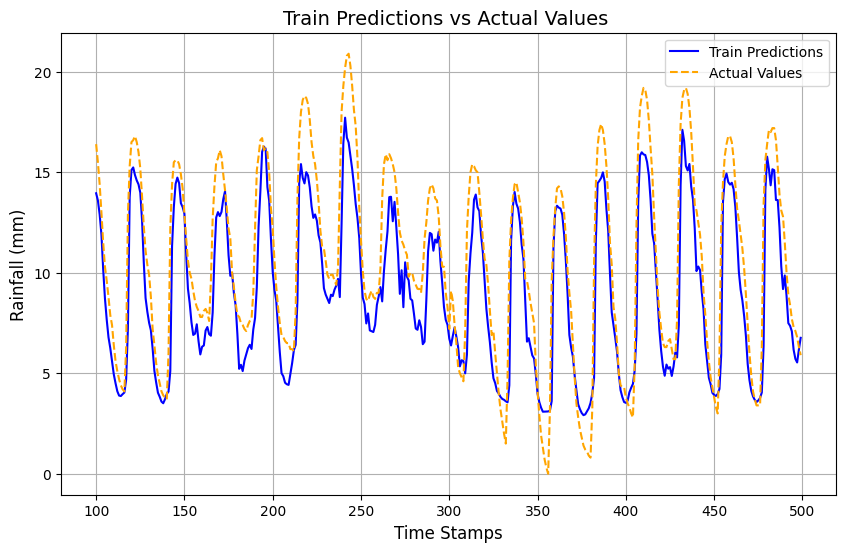

In [42]:
train_results = plot_predictions(
    model=model_gru, 
    X_data=X_train2, 
    y_data=y_train2, 
    label='Train', 
    start=100, 
    end=500
)

681/681 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
       Val Predictions  Actual Values
0            14.673468           18.6
1            16.202236           14.7
2            13.234234           15.4
3            14.732459           18.3
4            17.426727           17.2
...                ...            ...
21764        19.203938           22.2
21765        18.481176           21.6
21766        17.152462           21.2
21767        16.644512           21.4
21768        16.842089           21.0

[21769 rows x 2 columns]


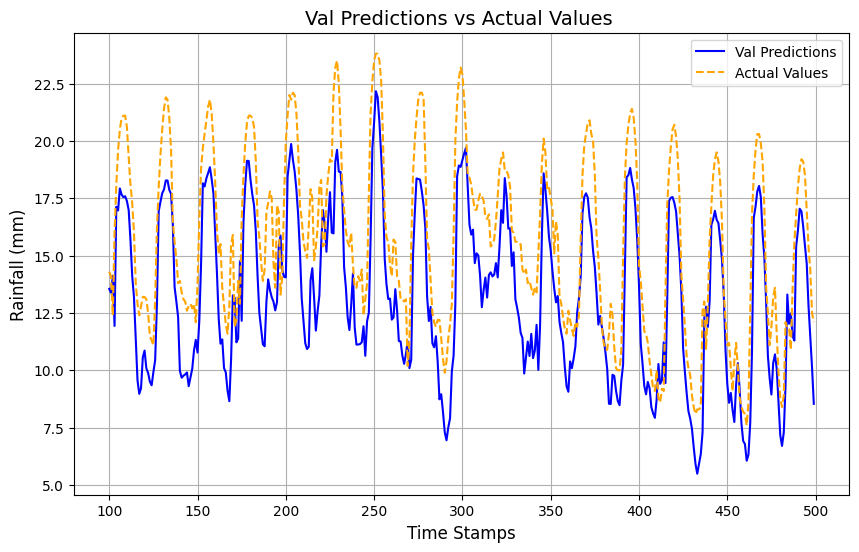

In [43]:
val_results = plot_predictions(
    model=model_gru, 
    X_data=X_val2, 
    y_data=y_val2, 
    label='Val', 
    start=100, 
    end=500
)

681/681 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
       Test Predictions  Actual Values
0             16.613148           20.3
1             16.143471           21.1
2             17.248688           21.4
3             17.759142           21.1
4             17.235209           23.5
...                 ...            ...
21766         12.604349           17.1
21767         12.387025           17.2
21768         13.425776           17.3
21769         13.669928           16.8
21770         13.531393           16.7

[21771 rows x 2 columns]


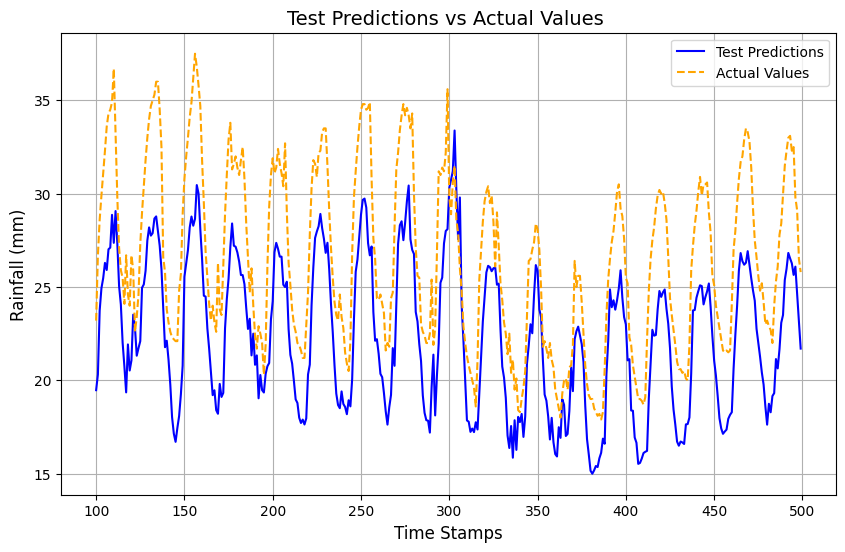

In [44]:
test_results = plot_predictions(
    model=model_gru, 
    X_data=X_test2, 
    y_data=y_test2, 
    label='Test', 
    start=100, 
    end=500
)

## 3.5 CNN 1D

In [45]:
model_cnn_1d = Sequential([
    InputLayer((16, 15)),
    Conv1D(64, kernel_size=2, activation='relu'),
    Conv1D(64, kernel_size=2, activation='relu'),
    GlobalAveragePooling1D(),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(8, 'relu'),
    Dense(1, 'linear')
])

model_cnn_1d.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 15, 64)         │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 14, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,425 (44.63 KB)

 Trainable params: 11,425 (44.63 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
history_cnn_1d = train_model(
    model=model_cnn_1d,
    checkpoint_path='../artifacts/models/multivariate/model_cnn_1d.keras',
    X_train=X_train2,
    y_train=y_train2,
    X_val=X_val2,
    y_val=y_val2,
    epochs=5
)

Epoch 1/5
5443/5443 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 74.7320 - root_mean_squared_error: 8.1592 - val_loss: 23.9763 - val_root_mean_squared_error: 4.8966
Epoch 2/5
5443/5443 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 11.7154 - root_mean_squared_error: 3.4210 - val_loss: 25.9147 - val_root_mean_squared_error: 5.0906
Epoch 3/5
5443/5443 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 7.9463 - root_mean_squared_error: 2.8184 - val_loss: 26.2361 - val_root_mean_squared_error: 5.1221
Epoch 4/5
5443/5443 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 6.3926 - root_mean_squared_error: 2.5281 - val_loss: 26.7833 - val_root_mean_squared_error: 5.1753
Epoch 5/5
5443/5443 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 5.5308 - root_mean_squared_error: 2.3515 - val_loss: 23.9979 - val_root_mean_squared_error: 4.8988


In [47]:
model_cnn_1d = load_model('../artifacts/models/multivariate/model_cnn_1d.keras')

## 3.6 CNN 1D Plot: Pred v/s Actual

5443/5443 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
        Train Predictions  Actual Values
0               11.376156           16.3
1               13.725616           16.7
2               15.665433           17.0
3               16.051929           16.9
4               15.611529           16.5
...                   ...            ...
174153          13.162567           18.9
174154          13.230401           18.4
174155          12.961055           16.1
174156          12.171072           17.1
174157          11.527383           17.5

[174158 rows x 2 columns]


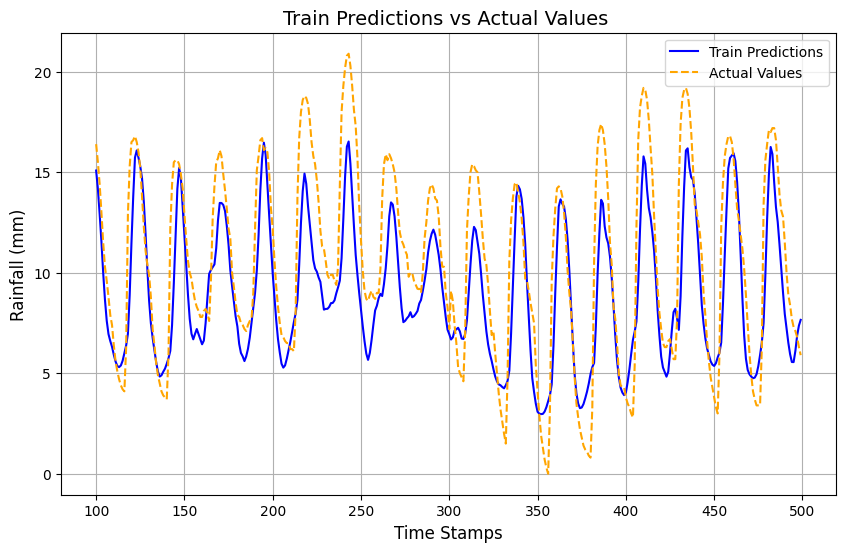

In [48]:
train_results = plot_predictions(
    model=model_cnn_1d, 
    X_data=X_train2, 
    y_data=y_train2, 
    label='Train', 
    start=100, 
    end=500
)

681/681 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
       Val Predictions  Actual Values
0            11.298348           18.6
1            11.538315           14.7
2            11.347317           15.4
3            11.024361           18.3
4            11.251512           17.2
...                ...            ...
21764        19.097952           22.2
21765        17.966042           21.6
21766        17.238726           21.2
21767        16.850004           21.4
21768        16.303314           21.0

[21769 rows x 2 columns]


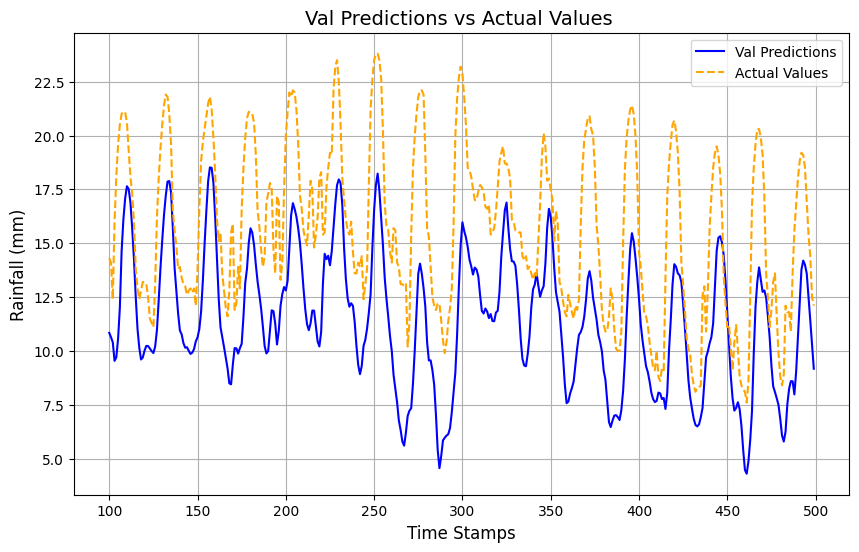

In [49]:
val_results = plot_predictions(
    model=model_cnn_1d, 
    X_data=X_val2, 
    y_data=y_val2, 
    label='Val', 
    start=100, 
    end=500
)

681/681 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
       Test Predictions  Actual Values
0             16.070614           20.3
1             16.000107           21.1
2             16.204578           21.4
3             16.533844           21.1
4             16.887653           23.5
...                 ...            ...
21766         13.717690           17.1
21767         13.240159           17.2
21768         12.851828           17.3
21769         12.630792           16.8
21770         12.650520           16.7

[21771 rows x 2 columns]


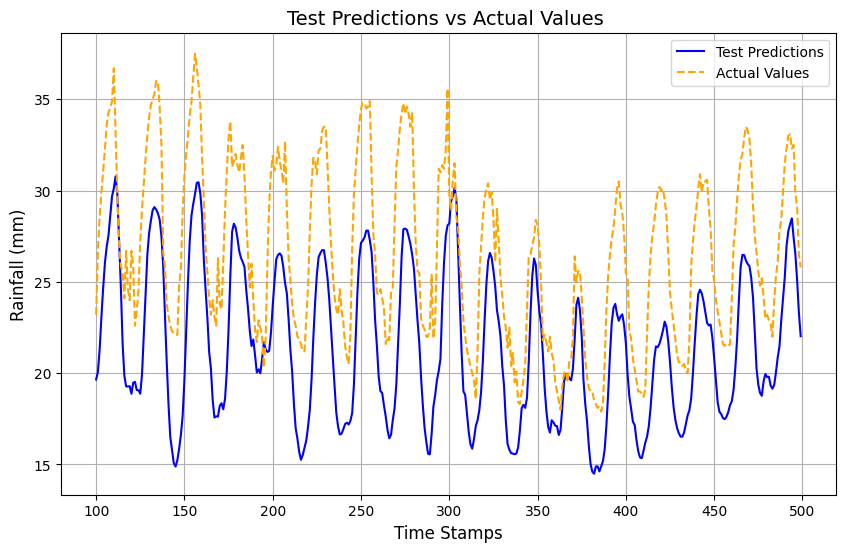

In [50]:
test_results = plot_predictions(
    model=model_cnn_1d, 
    X_data=X_test2, 
    y_data=y_test2, 
    label='Test', 
    start=100, 
    end=500
)